Assign 8 (Lab 4): Transfer Learning with a CNN
======================================

This notebook has been adapted from the [PyTorch tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).
Similar to the original tutorial, this one will demonstrate two different variations of transfer learning.

As discussed in class, __[transfer learning](https://en.wikipedia.org/wiki/Transfer_learning)__ in machine learning is about utilizing an already-trained model for your specific problem or use case.

Large neural networks can take a significant amount of resources to train, in terms of long training time,
massive dataset size, and costly computer hardware. Given that, it's
no surprise that we would want to avoid training a model from scratch. This is where transfer learning comes in.

Transfer learning starts by taking a pre-trained neural network model that was trained to, say, predict which of
1000 possible types of animals is in an image. This model is then used/repurposed/recycled to, say, predict which of two animals
is in an image. Note that two types of animals that you want to perform classification on don't even need to be part of the original 1000 animals.

There are two types of transfer learning techniques we'll try. Technically, we will be using the exact same model architecture with the pre-trained parameters, but they will be different instances of the model. We will refer to them as Approach A and Approach B. The differences are:

-   **Approach A: Finetuning the ConvNet** - Start with the pre-trained model, change the final output layer to have only 2 units (or neurons), and then fine-tune or refit the model on our Ant and Bee images. All the parameter values can change. 
-   **Approach B: ConvNet as fixed feature extractor** - Again, start with the pre-trained model, change the final output layer to have only 2 units (or neurons), but this time only allow the parameter values in the (new) final layer to be modified.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/CS3120/blob/main/lab4_transfer_learning.ipynb)

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/sgeinitz/CS3120/blob/main/lab4_transfer_learning.ipynb)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

# diable warnings
import warnings
warnings.filterwarnings("ignore")


# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
!git clone https://github.com/sgeinitz/CS3120.git

Cloning into 'CS3120'...
remote: Enumerating objects: 466, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 466 (delta 11), reused 15 (delta 5), pack-reused 445 (from 2)
Receiving objects: 100% (466/466), 46.27 MiB | 17.29 MiB/s, done.
Resolving deltas: 100% (24/24), done.


Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. 

Trying to train a deep learning model from scratch with just one or two hundred images is not really possible. 
But, we're not going to train the deep learning model from scratch. Instead, we're going to use one that was already trained on millions 
of images to classify which of one-thousand (1000) possible categories the contents of the image falls into. 
We'll then going to fine tune the model for our specific problem of binary classification, namely: Bee or Ant (i.e, not Bee)).

Since we are using transfer learning, and *not* training the model from scratch, one or two hundred images is plenty.



NOTE: This is where `batch_size` is size (technically speaking, we're talking about the mini-batch size). Questions 3 and 4 below will ask you to come back 
and change this, but wait until you've run it one time with `batch_size=16` before changing it. 


In [44]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'CS3120/lab4_transfer_learning_images/hymenoptera'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# check for a GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
# check for an Apple MPS device
elif torch.backends.mps.is_available():
    device = torch.device("mps")
# otherwise use the CPU
else:
    device = torch.device("cpu")

# print out which device is being used
print(f"Using device: {device}")

Using device: cpu


Examine a few Images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.

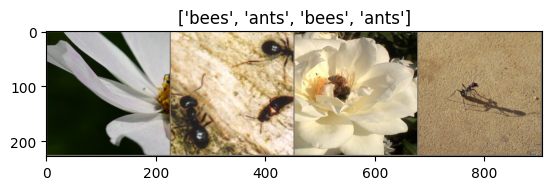

In [45]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
==================

Now, let\'s write a general function to train a model. 

Notice that in addition to using mini-batches, there is another so-called _trick_ we're using. Namely, the use 
of a __scheduler__ to modify the learning rate over time. 

In the following, parameter `scheduler` is a LR scheduler object from
`torch.optim.lr_scheduler`. Right now it is only a a parameter in the `train_model` function, but you will see 
it declared/instantiated later on in this notebook. 


In [46]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    b_losses = {'train':[], 'val':[]}
    e_losses = {'train':[], 'val':[]}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    b_losses[phase].append(loss.item())

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                # print loss and accuraacy every 4 epochs
                if epoch % 4 == 0:
                    print('-' * 10)
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                # save loss for plotting later on
                e_losses[phase].append(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, e_losses, b_losses

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [47]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Approach A: Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.

This is also where we create instances of the `optimizer` and `scheduler` objects, both of which are then passed into 
the `train_model` function as parameters. 

In [48]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# In general, this could be written as ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
==================

This will take 1-2 minutes on a GPU, or around 20-25 minutes with a CPU. 


In [49]:
model_ft, epoch_losses, batch_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6059 Acc: 0.7049
----------
val Loss: 0.2791 Acc: 0.8824

Epoch 1/24

Epoch 2/24

Epoch 3/24

Epoch 4/24
----------
train Loss: 0.5235 Acc: 0.7623
----------
val Loss: 0.3805 Acc: 0.8693

Epoch 5/24

Epoch 6/24

Epoch 7/24

Epoch 8/24
----------
train Loss: 0.3497 Acc: 0.8566
----------
val Loss: 0.2408 Acc: 0.9150

Epoch 9/24

Epoch 10/24

Epoch 11/24

Epoch 12/24
----------
train Loss: 0.3838 Acc: 0.8156
----------
val Loss: 0.2586 Acc: 0.9020

Epoch 13/24

Epoch 14/24

Epoch 15/24

Epoch 16/24
----------
train Loss: 0.2863 Acc: 0.8730
----------
val Loss: 0.2411 Acc: 0.9085

Epoch 17/24

Epoch 18/24

Epoch 19/24

Epoch 20/24
----------
train Loss: 0.2834 Acc: 0.8934
----------
val Loss: 0.2461 Acc: 0.9216

Epoch 21/24

Epoch 22/24

Epoch 23/24

Epoch 24/24
----------
train Loss: 0.2398 Acc: 0.8975
----------
val Loss: 0.2607 Acc: 0.8954

Training complete in 11m 36s
Best val Acc: 0.921569


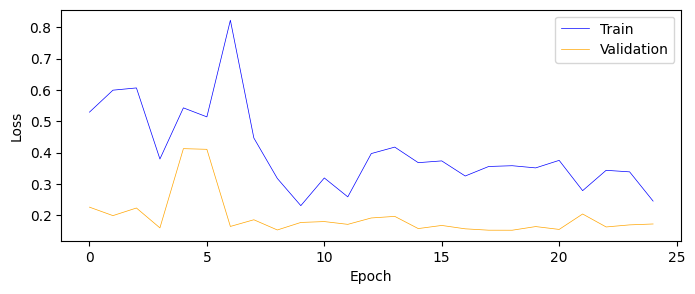

In [56]:
# plot the loss curves
plt.figure(figsize=(8, 3))
plt.plot(range(len(epoch_losses['train'])), epoch_losses['train'], c='blue', linewidth=0.5)
plt.plot(range(len(epoch_losses['val'])), epoch_losses['val'], c='orange', linewidth=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(('Train','Validation'))
plt.show()

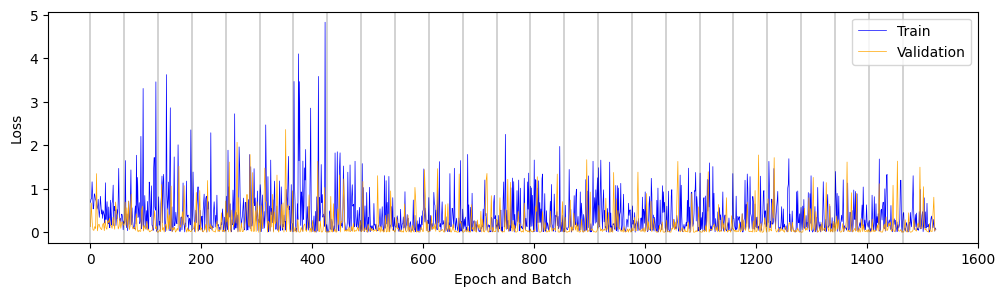

In [57]:
# plot the loss curves for each (mini) batch
plt.figure(figsize=(12, 3))
val_ticks = [(i)*len(batch_losses['train'])/len(batch_losses['val']) for i in range(len(batch_losses['val']))]
plt.plot(range(len(batch_losses['train'])), batch_losses['train'], c='blue', linewidth=0.5)
plt.plot(val_ticks, batch_losses['val'], c='orange', linewidth=0.5)
for i in range(25):
    plt.axvline(x=i*len(batch_losses['train'])/25, c='black', lw=0.25)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))
plt.show()

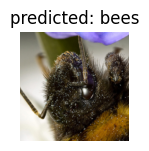

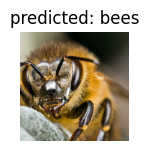

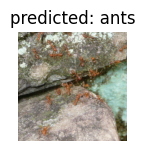

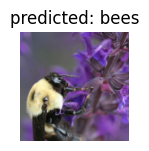

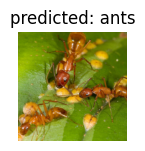

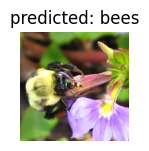

In [38]:
visualize_model(model_ft)

Approach B: ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [52]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
==================

Now use `train_model` again, but with the above model object, which has frozen all the parameters except for those in the final layer. 

***
### Q1: Will this run faster or slower than the earlier training run? Explain why or why not?

\<This will run a lot faster because unlike approch A, approch B only has to update the last output layer instead of the whole thing, this means an epoch for A is the whole NN while an epoch for B is just the last two nurons\>
***

In [53]:
model_conv, epoch_losses, batch_losses = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5290 Acc: 0.7705
----------
val Loss: 0.2261 Acc: 0.9216

Epoch 1/24

Epoch 2/24

Epoch 3/24

Epoch 4/24
----------
train Loss: 0.5427 Acc: 0.7582
----------
val Loss: 0.4126 Acc: 0.8301

Epoch 5/24

Epoch 6/24

Epoch 7/24

Epoch 8/24
----------
train Loss: 0.3176 Acc: 0.8730
----------
val Loss: 0.1533 Acc: 0.9542

Epoch 9/24

Epoch 10/24

Epoch 11/24

Epoch 12/24
----------
train Loss: 0.3970 Acc: 0.8361
----------
val Loss: 0.1916 Acc: 0.9542

Epoch 13/24

Epoch 14/24

Epoch 15/24

Epoch 16/24
----------
train Loss: 0.3254 Acc: 0.8320
----------
val Loss: 0.1569 Acc: 0.9477

Epoch 17/24

Epoch 18/24

Epoch 19/24

Epoch 20/24
----------
train Loss: 0.3753 Acc: 0.8484
----------
val Loss: 0.1551 Acc: 0.9477

Epoch 21/24

Epoch 22/24

Epoch 23/24

Epoch 24/24
----------
train Loss: 0.2454 Acc: 0.8811
----------
val Loss: 0.1724 Acc: 0.9542

Training complete in 5m 28s
Best val Acc: 0.960784


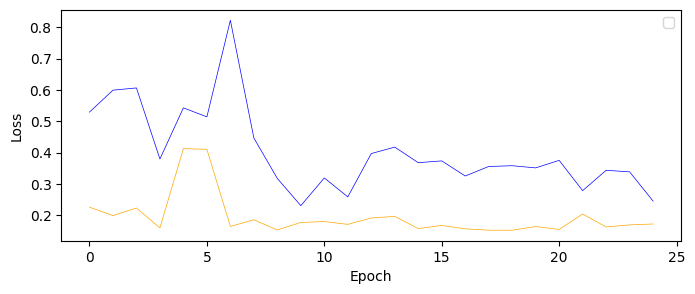

In [58]:
# plot the loss curves
plt.figure(figsize=(8, 3))
plt.plot(range(len(epoch_losses['train'])), epoch_losses['train'], c='blue', linewidth=0.5)
plt.plot(range(len(epoch_losses['val'])), epoch_losses['val'], c='orange', linewidth=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend('Train','Validation')
plt.show()

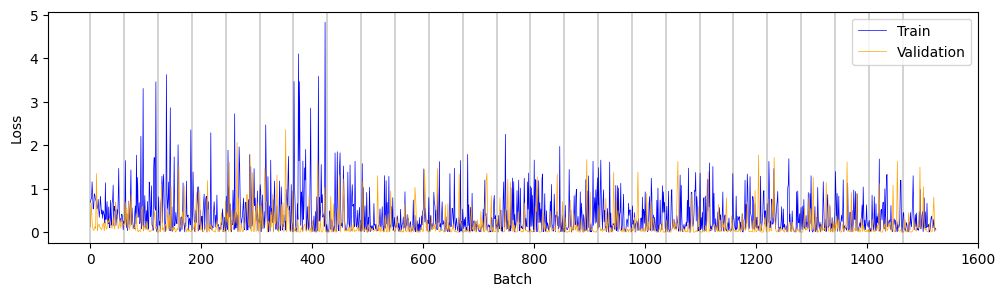

In [59]:
# plot the loss curves for each (mini) batch
plt.figure(figsize=(12, 3))
val_ticks = [(i)*len(batch_losses['train'])/len(batch_losses['val']) for i in range(len(batch_losses['val']))]
plt.plot(range(len(batch_losses['train'])), batch_losses['train'], c='blue', linewidth=0.5)
plt.plot(val_ticks, batch_losses['val'], c='orange', linewidth=0.5)
for i in range(25):
    plt.axvline(x=i*len(batch_losses['train'])/25, c='black', lw=0.25)
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.legend(('Train','Validation'))
plt.show()

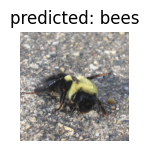

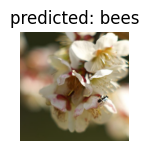

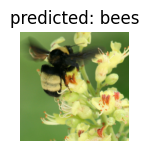

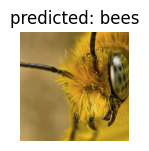

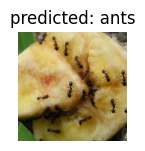

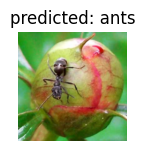

In [43]:
visualize_model(model_conv)

plt.ioff()
plt.show()

***
### Q2: Which of the two approaches worked best (in terms of validation accuracy)? Approach A or Approach B? Explain why you think this might be?

\<With a validation ACC of .97 approach A works best by far compared to B's .49 validation ACC. Even though they had they had the same number of epochs and mini batch sizes, Approach A has a lower validation ACC becuase every nuron is having its weights adjusted as opposed to B where its using the weights of the trained model before it, then updating only the bias of the output layer.\>
***

***
### Q3: Change the batch size from 16 to 32 and then re-run both model training runs. How does this change the training and performance?

\<The training time for both bach 16 and 32 runs both took the same amount of time I think. But approach B ACC improved by a lot, it went from .49 to validation accuracy!\>
***




***
### Q4: Change the batch size from 32 to 4 and then re-run both model training runs. How does this change the training and performance?  Also comment on whether there are now more or less mini-batches. 

\< Again the traning time felt the same for both approaches. Approach A's validation ACC went down by about 2% and Approach B's increased by 1%. And you will get a lot more mini batches with a batch size of 4 then 32.\>
***

***
### Q5: Look at the loss curves when the batch size was 32 and compare them to when the batch size of 4. For which batch size were the loss curves more bumpy or jagged? Explain why this is?  

\<The batch curves were more jagged with the a batch size of 4 then that of 32, this could be because when you 'jump around' the loss surface the model has less of an idea of where its at becuase its batch size is smaller, so when the model trains it 'sees' less of the surface so that would make the optimizations in the loss look more sloppy or jagged.\>
***

Inference on one Images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [61]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

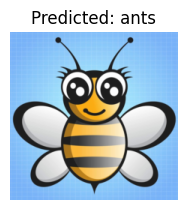

In [71]:
visualize_model_predictions(
    model_conv,
    # img_path='CS3120/lab4_transfer_learning_images/hymenoptera/val/bees/72100438_73de9f17af.jpg'
    img_path='./CS3120/images/insect_of_sorts.jpg'
)

plt.ioff()
plt.show()

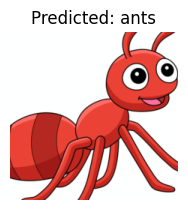

In [78]:
visualize_model_predictions(
    model_conv,
    # img_path='CS3120/lab4_transfer_learning_images/hymenoptera/val/bees/72100438_73de9f17af.jpg'
    # img_path='./CS3120/images/insect_of_sorts.jpg'
    img_path='./CS3120/images/sorts_of_insect.jpeg'
    
)

plt.ioff()
plt.show()